In [1]:
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydeck as pdk

sns.set(style="whitegrid")
sns.set_context("paper")

In [2]:
import os
import sys

if './src' not in sys.path:
    sys.path.append('./src')

In [3]:
from config import config

os.environ["MAPBOX_API_KEY"] = config['mapbox']['token']

In [4]:
data = pd.read_csv('output/results/model_v0.2_dec_500.csv', index_col=0)
# data.loc[:, 'f1'] = data.loc[:, 'f1_test'].apply(lambda x: float(x.strip('%')) / 100)
# data.loc[:, 'roc_auc'] = data.loc[:, 'roc_auc_test'].apply(lambda x: float(x.strip('%')) / 100)

records = []

for i in range(len(data)):
    record = data.iloc[i]
    temp = record[['year','month','radius','aperture_size','incident_interval','time_step','select']].to_dict()
    for col in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']:
        temp_col = {'scorer': col, 'score': record[col]}
        temp_col.update(temp)
        records.append(temp_col)

data = pd.DataFrame(records)

data.head()

,scorer,score,year,month,radius,aperture_size,incident_interval,time_step,select
0,test_accuracy,0.775177,2019.0,12.0,500.0,6.0,15.0,5.0,500.0
1,test_precision,0.253875,2019.0,12.0,500.0,6.0,15.0,5.0,500.0
2,test_recall,0.546667,2019.0,12.0,500.0,6.0,15.0,5.0,500.0
3,test_f1,0.330459,2019.0,12.0,500.0,6.0,15.0,5.0,500.0
4,test_roc_auc,0.734464,2019.0,12.0,500.0,6.0,15.0,5.0,500.0


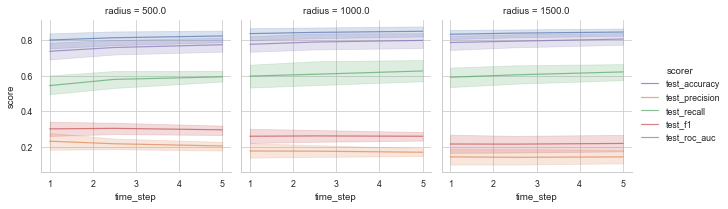

In [5]:
g = sns.FacetGrid(data, col='radius', hue='scorer')

g.map(sns.lineplot, 'time_step', 'score', alpha=.7)

g.add_legend()

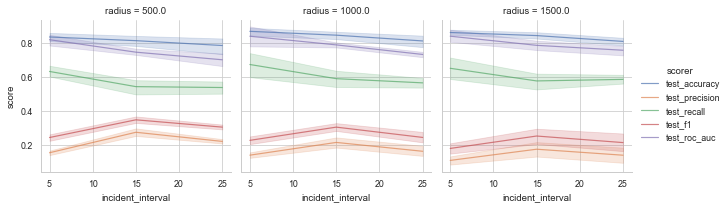

In [6]:
g = sns.FacetGrid(data, col="radius", hue='scorer')

g.map(sns.lineplot, "incident_interval", "score", alpha=.7)

g.add_legend()

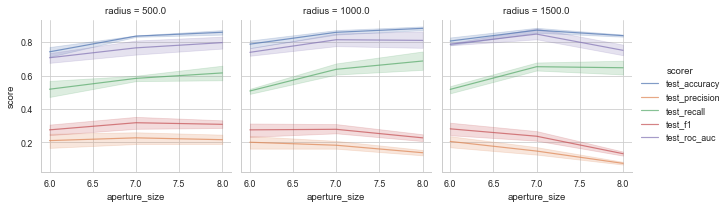

In [7]:
g = sns.FacetGrid(data, col="radius", hue='scorer')

g.map(sns.lineplot, "aperture_size", "score", alpha=.7)

g.add_legend()

## Prior Analyis

In [8]:
import sys
import h3
import numpy as np

sys.path.append('./src')

from dataset import load_incidents

In [29]:
aperture_size = 7

df_freq = load_incidents(aperture_size)

df_freq = df_freq[df_freq.time < '2019-10-01']

df_freq.head()

,segment_id,lat,lng,timestamp,count,time,region
12,75,36.33824,-86.91432,1.566950e+09,1,2019-08-27 23:56:00,87264dc74ffffff
19,76,36.32822,-86.89224,1.567493e+09,1,2019-09-03 06:36:00,87264dc66ffffff
29,78,36.32453,-86.86942,1.567221e+09,1,2019-08-31 03:05:00,87264dc66ffffff
34,78,36.32506,-86.87614,1.564770e+09,1,2019-08-02 18:14:00,87264dc66ffffff
42,80,36.32392,-86.86774,1.567175e+09,1,2019-08-30 14:25:00,87264dc64ffffff


In [30]:
def region_prior(region, hour):
    resolution = h3.h3_get_resolution(region)
    incident_df = load_incidents(resolution, df_freq)
    # change to historical data values
    # use labels_prv to prevent overfitting
    # return 1 / len(np.unique(labels.region))
    lower = len(incident_df) + len(np.unique(incident_df.region)) * 24
    prior = (np.sum((incident_df.region == region) & (incident_df.time.dt.hour == hour)) + 1) / lower
    # prior = np.sum(incident_df['region'] == region[2:]) / len(incident_df)
    return prior

In [31]:
min(df_freq.time), max(df_freq.time)

(Timestamp('2019-08-01 05:00:00'), Timestamp('2019-09-30 22:57:00'))

In [32]:
records = []

for region in tqdm.tqdm(np.unique(df_freq.region)):
    for hour in range(24):
        records.append({
           'region': region, 'hour': (hour - 5), 'prior':region_prior(region, hour)
        })

priors_df = pd.DataFrame(records)

100%|██████████| 94/94 [02:14<00:00,  1.43s/it]


In [33]:
priors_df.head()

,region,hour,prior
0,87264d020ffffff,-5,0.000262
1,87264d020ffffff,-4,0.000524
2,87264d020ffffff,-3,0.000262
3,87264d020ffffff,-2,0.000262
4,87264d020ffffff,-1,0.000262


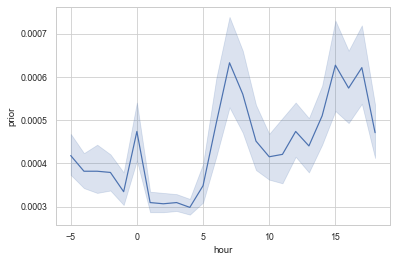

In [34]:
ax = sns.lineplot(x="hour", y="prior", data=priors_df)

In [43]:
df = priors_df[priors_df.hour < 8].groupby('region')[['prior']].mean().reset_index()

df.loc[:, 'prior'] = (df['prior'] - min(df['prior'])) / (max(df['prior']) - min(df['prior']))

# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    df,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon="region",
    get_fill_color="[(1-prior) * 255, 0, 0]",
    get_line_color=[255, 255, 255],
    line_width_min_pixels=2,
)

# Set the viewport location
view_state = pdk.ViewState(latitude=36.1627, longitude=-86.7816, zoom=11, bearing=0, pitch=0)


# Render
r = pdk.Deck(map_style="mapbox://styles/mapbox/light-v9", layers=[layer], initial_view_state=view_state, tooltip={"text": "Density: {prior}"})

r.show()

DeckGLWidget(json_input='{"initialViewState": {"bearing": 0, "latitude": 36.1627, "longitude": -86.7816, "pitc…

In [42]:
df = priors_df[priors_df.hour >= 8].groupby('region')[['prior']].mean().reset_index()

df.loc[:, 'prior'] = (df['prior'] - min(df['prior'])) / (max(df['prior']) - min(df['prior']))

# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    df,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon="region",
    get_fill_color="[(1-prior) * 255, 0, 0]",
    get_line_color=[255, 255, 255],
    line_width_min_pixels=2,
)

# Set the viewport location
view_state = pdk.ViewState(latitude=36.1627, longitude=-86.7816, zoom=11, bearing=0, pitch=0)


# Render
r = pdk.Deck(map_style="mapbox://styles/mapbox/light-v9", layers=[layer], initial_view_state=view_state, tooltip={"text": "Density: {prior}"})

r.show()

DeckGLWidget(json_input='{"initialViewState": {"bearing": 0, "latitude": 36.1627, "longitude": -86.7816, "pitc…

### Raw Data Analysis

In [62]:
nv_report_data = pd.read_pickle(f'output/waze/2019_12_1500_region.pkl')

layer = pdk.Layer(
    'ScatterplotLayer',
    nv_report_data,
    get_position=['lng', 'lat'],
    auto_highlight=True,
    get_radius=1000,          # Radius is given in meters
    get_fill_color=[180, 0, 200, 140],  # Set an RGBA value for fill
    pickable=True
)

# Set the viewport location
view_state = pdk.ViewState(latitude=36.1627, longitude=-86.7816, zoom=11, bearing=0, pitch=0)


# Render
r = pdk.Deck(map_style="mapbox://styles/mapbox/light-v9", layers=[layer], initial_view_state=view_state)

r.show()

DeckGLWidget(json_input='{"initialViewState": {"bearing": 0, "latitude": 36.1627, "longitude": -86.7816, "pitc…